In [ ]:
#!/usr/bin/env python3
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install seqeval
import os
import json
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from seqeval.metrics.sequence_labeling import get_entities

from datasets import Dataset, DatasetDict
from transformers import (
    BertTokenizerFast,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
)
from transformers import AutoTokenizer, AutoModel
import evaluate

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import shap
from sklearn.model_selection import GridSearchCV

os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
os.environ.setdefault("HF_DATASETS_DISABLE_MP", "1")

'1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configurations
INPUT_CSV = "/content/drive/My Drive/DS266/Final Project/data/absa_features_with_spans_withgpt.csv"
TEXT_COL = "Catalyst"
SPAN_COL = "auto_spans"
MODEL_NAME = "bert-base-cased"
MAX_LENGTH = 256
VAL_FRACTION = 0.2
SEED = 42

# Functions for creating the BIO tags and saving results

In [ ]:
def char_spans_to_word_bio(text, span_dicts):
    """
    text: raw string
    span_dicts: list of {"start": int, "end": int, "label": "EFF_POS", ...}
    Returns:
      tokens: [str, ...]
      bio_tags: [str, ...] like "B-EFF_POS", "I-EFF_POS", "O"
    """

    if text is None:
        text = ""
    text = str(text)
    tokens = text.split()




    if not tokens:
        return [], []

    # convert spans to list of tuples for convenience
    spans = [(s["start"], s["end"], s["label"]) for s in span_dicts]

    # for each token, compute its char start/end (based on find from current offset)
    bio_tags = []
    offset = 0
    prev_underlying = None

    for tok in tokens:
        start = text.find(tok, offset)
        if start == -1:  # fallback if not found
            start = offset
        end = start + len(tok)
        offset = end

        # find all spans that fully contain this token
        candidates = [
            (s_start, s_end, lab)
            for (s_start, s_end, lab) in spans
            if start >= s_start and end <= s_end
        ]

        if not candidates:
            bio_tags.append("O")
            prev_underlying = None
            continue

        # if multiple, choose the longest span (or just first)
        s_start, s_end, lab = sorted(
            candidates,
            key=lambda x: (x[0], -(x[1] - x[0]))
        )[0]

        # underlying semantic label, e.g. "EFF_POS"
        underlying = lab

        # Decide B- vs I-:
        if prev_underlying == underlying:
            tag = f"I-{underlying}"
        else:
            tag = f"B-{underlying}"

        bio_tags.append(tag)
        prev_underlying = underlying

    return tokens, bio_tags

def load_ner_dataset(csv_path):
    df = pd.read_csv(csv_path)

    # Parse JSON spans and build tokens + BIO
    ner_rows = []
    for _, row in df.iterrows():
        text = row.get(TEXT_COL, "")
        spans_raw = row.get(SPAN_COL, "[]")
        try:
            span_dicts = json.loads(spans_raw) if isinstance(spans_raw, str) else spans_raw
        except json.JSONDecodeError:
            span_dicts = []

        tokens, bio = char_spans_to_word_bio(text, span_dicts)

        if not tokens:
            continue

        row_dict = row.to_dict()

        # Add new NER-specific fields
        row_dict["tokens"] = tokens
        row_dict["ner_tags_str"] = bio

        ner_rows.append(row_dict)

    # Build HF Dataset with all columns preserved
    dataset = Dataset.from_pandas(pd.DataFrame(ner_rows), preserve_index=False)
    return dataset

def build_labels(dataset):
    all_tags = set(tag for seq in dataset["ner_tags_str"] for tag in seq)
    # ensure deterministic ordering: O first, then others sorted
    label_list = ["O"] + sorted(t for t in all_tags if t != "O")
    label2id = {l: i for i, l in enumerate(label_list)}
    id2label = {i: l for l, i in label2id.items()}
    return label_list, label2id, id2label

def tokenize_and_align_labels(examples, tokenizer, label2id):
    # examples["tokens"] is a list of lists of tokens
    tokenized = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )

    all_labels = []
    for i, word_labels in enumerate(examples["ner_tags_str"]):
        word_ids = tokenized.word_ids(batch_index=i)
        labels = []
        prev_word_id = None
        for word_id in word_ids:
            if word_id is None:
                labels.append(-100)
            else:
                # For subwords: only label the first subword
                if word_id != prev_word_id:
                    tag = word_labels[word_id]
                    labels.append(label2id[tag])
                else:
                    # set to -100 so loss ignores
                    labels.append(-100)
            prev_word_id = word_id
        all_labels.append(labels)

    tokenized["labels"] = all_labels
    return tokenized

seqeval_metric = evaluate.load("seqeval")

def compute_metrics(p, label_list):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)

    true_labels = []
    true_preds  = []

    for pred, lab in zip(predictions, labels):
        cur_preds = []
        cur_labels = []
        for p_i, l_i in zip(pred, lab):
            if l_i == -100:
                continue
            cur_preds.append(label_list[p_i])
            cur_labels.append(label_list[l_i])
        true_preds.append(cur_preds)
        true_labels.append(cur_labels)

    results = seqeval_metric.compute(predictions=true_preds, references=true_labels)
    # results is like {'overall_precision': ..., 'overall_recall': ..., 'overall_f1': ..., 'overall_accuracy': ...}
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

def evaluate_ner(trainer, tokenized_dataset_split, id2label, seqeval_metric):
    """
    Evaluate a token classification model on a dataset split.

    Returns:
      results_full_df: pandas DataFrame with per-label and overall metrics
      true_preds: list of predicted label sequences (BIO)
      true_labels: list of true label sequences (BIO)
      pred_ids: raw predicted label IDs
    """
    # 1) Predict
    predictions_output = trainer.predict(tokenized_dataset_split)
    logits = predictions_output.predictions
    labels = predictions_output.label_ids

    # 2) Convert logits → predicted IDs
    pred_ids = logits.argmax(axis=-1)

    # 3) Convert IDs → BIO label strings (ignoring -100)
    true_preds = []
    true_labels = []

    for pred_row, label_row in zip(pred_ids, labels):
        pred_seq = []
        label_seq = []

        for p, l in zip(pred_row, label_row):
            if l == -100:
                continue
            pred_seq.append(id2label[p])
            label_seq.append(id2label[l])

        true_preds.append(pred_seq)
        true_labels.append(label_seq)

    # 4) Compute seqeval metrics
    results = seqeval_metric.compute(
        predictions=true_preds,
        references=true_labels
    )

    # 5) Build dataframe
    label_keys = [k for k in results.keys() if not k.startswith("overall")]

    results_df = pd.DataFrame.from_dict(
        {k: results[k] for k in label_keys},
        orient="index"
    )

    results_df_overall = pd.DataFrame([{
        "accuracy": results["overall_accuracy"],
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "number": None
    }], index=["OVERALL"])

    results_full_df = pd.concat([results_df, results_df_overall])

    return results_full_df, true_preds, true_labels, pred_ids

# function to save the information from the model
def save_ner_artifacts(
    folder,
    id2label,
    label2id,
    eval_results,
    seqeval_metric,
    true_preds,
    true_labels,
    ds,
    tokenized_ds,
    pred_ids,
    results_full_df,
):
    """
    Saves all NER evaluation artifacts:
    - labels.json
    - metrics.json
    - seqeval per-label text report
    - per-label CSV table
    - predictions.jsonl with tokens + decoded labels
    - confusion_matrix.txt
    """

    # Ensure folder exists
    os.makedirs(folder, exist_ok=True)

    # ------------------ SAVE LABEL MAP ------------------
    with open(f"{folder}/labels.json", "w") as f:
        json.dump({"id2label": id2label, "label2id": label2id}, f, indent=2)

    # ------------------ SAVE METRICS ---------------------
    with open(f"{folder}/metrics.json", "w") as f:
        json.dump(eval_results, f, indent=2)

    # ------------------ DETAILED LABEL REPORT -------------
    detailed = seqeval_metric.compute(
        predictions=true_preds,
        references=true_labels
    )
    with open(f"{folder}/per_label_report.txt", "w") as f:
        for label, vals in detailed.items():
            f.write(f"{label}: {vals}\n")

    # ------------------ SAVE RESULTS CSV ------------------
    results_full_df.to_csv(
        f"{folder}/ner_per_label_metrics.csv",
        index=True
    )

    # ------------------ SAVE PREDICTIONS JSONL ------------------
    with open(f"{folder}/predictions.jsonl", "w") as f:
        for tokens, pred_seq, true_seq in zip(
            ds["test"]["tokens"],
            pred_ids,
            tokenized_ds["test"]["labels"]
        ):
            decoded_pred = []
            decoded_true = []

            for p, t in zip(pred_seq, true_seq):
                if t == -100:
                    continue
                decoded_pred.append(id2label[p])
                decoded_true.append(id2label[t])

            f.write(json.dumps({
                "tokens": tokens,
                "predicted": decoded_pred,
                "true": decoded_true
            }) + "\n")

    # ------------------ CONFUSION MATRIX ------------------
    flat_pred = [p for seq in true_preds for p in seq]
    flat_true = [t for seq in true_labels for t in seq]

    labels_sorted = sorted(list(set(flat_true)))

    cm = confusion_matrix(flat_true, flat_pred, labels=labels_sorted)
    np.savetxt(f"{folder}/confusion_matrix.txt", cm, fmt="%d")

    print(f"All NER artifacts saved to: {folder}")

# Load data, train and evaluate model using BioBERT Model with best hyperparameters

In [ ]:
# load in the NER dataset using function that makes the spans in BIO
dataset = load_ner_dataset(INPUT_CSV)

# build labels
label_list, label2id, id2label = build_labels(dataset)
num_labels = len(label_list)
print("Labels:", label_list)

# split into training and testing set
dates = pd.to_datetime(dataset["Date"])
cutoff_date =  pd.to_datetime("2024-10-01")
train_idx = [i for i, d in enumerate(dates) if d <= cutoff_date]
test_idx  = [i for i, d in enumerate(dates) if d > cutoff_date]

ds = DatasetDict({
        "train": dataset.select(train_idx),
        "test": dataset.select(test_idx),
    })


Labels: ['O', 'B-CLIN_NEG', 'B-CLIN_POS', 'B-CONF_POS', 'B-EFF_NEG', 'B-EFF_POS', 'B-ENROLL_NEG', 'B-ENROLL_POS', 'B-REG_NEG', 'B-REG_NEUTRAL', 'B-REG_POS', 'B-SAFETY_NEG', 'B-SAFETY_POS', 'I-CLIN_NEG', 'I-CLIN_POS', 'I-CONF_POS', 'I-EFF_NEG', 'I-EFF_POS', 'I-ENROLL_NEG', 'I-ENROLL_POS', 'I-REG_NEG', 'I-REG_POS', 'I-SAFETY_NEG', 'I-SAFETY_POS']


### Modeling with biobert

In [ ]:
MODEL_NAME = "dmis-lab/biobert-base-cased-v1.2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
# tokenize
def _tokenize(examples):
    return tokenize_and_align_labels(examples, tokenizer, label2id)

tokenized_ds = ds.map(_tokenize, batched=True, remove_columns=["tokens", "ner_tags_str"])


Map:   0%|          | 0/2092 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
model_biobert = AutoModelForTokenClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
    )

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
folder = '/content/drive/My Drive/DS266/Final Project/runs/biobert_ner_final'

training_args_biobert = TrainingArguments(
        output_dir="/content/drive/My Drive/DS266/Final Project/models/biobert_ner_final",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        seed=SEED,
        report_to=["tensorboard"],
    )

In [ ]:
trainer_biobert = Trainer(
        model=model_biobert,
        args=training_args_biobert,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        tokenizer=tokenizer,
        compute_metrics=lambda p: compute_metrics(p, label_list),
    )

/tmp/ipython-input-1960334025.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_biobert = Trainer(


In [ ]:
trainer_biobert.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.576223,0.139742,0.158605,0.148577,0.790656
2,0.575100,0.487804,0.181818,0.209224,0.194561,0.826002
3,0.575100,0.488147,0.222591,0.226097,0.224330,0.840330
4,0.309400,0.494710,0.194767,0.226097,0.209266,0.833528
5,0.309400,0.527568,0.208791,0.235096,0.221164,0.838825


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-sco

TrainOutput(global_step=1310, training_loss=0.39205499896566376, metrics={'train_runtime': 206.9602, 'train_samples_per_second': 50.541, 'train_steps_per_second': 6.33, 'total_flos': 1366853851791360.0, 'train_loss': 0.39205499896566376, 'epoch': 5.0})

In [ ]:
os.makedirs(folder, exist_ok=True)
#trainer_biobert.model.config.to_json_file(f"{folder}/config.json")

In [ ]:
eval_results_biobert = trainer_biobert.evaluate()
print("Final eval:", eval_results_biobert)

Final eval: {'eval_loss': 0.48814657330513, 'eval_precision': 0.22259136212624583, 'eval_recall': 0.22609673790776152, 'eval_f1': 0.22433035714285712, 'eval_accuracy': 0.8403300440430396, 'eval_runtime': 3.7572, 'eval_samples_per_second': 217.717, 'eval_steps_per_second': 27.414, 'epoch': 5.0}


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
results_full_df_biobert, true_preds_biobert, true_labels_biobert, pred_ids_biobert = evaluate_ner(
    trainer_biobert,
    tokenized_ds["test"],
    id2label,
    seqeval_metric
)

results_full_df_biobert

,precision,recall,f1,number,accuracy
CLIN_NEG,0.000000,0.000000,0.000000,11,NaN
CLIN_POS,0.407407,0.305556,0.349206,36,NaN
CONF_POS,0.000000,0.000000,0.000000,2,NaN
EFF_NEG,0.181818,0.216216,0.197531,37,NaN
EFF_POS,0.160777,0.157712,0.159230,577,NaN
ENROLL_NEG,0.000000,0.000000,0.000000,4,NaN
ENROLL_POS,0.409091,0.642857,0.500000,14,NaN
REG_NEG,0.500000,0.277778,0.357143,18,NaN
REG_POS,0.377358,0.449438,0.410256,89,NaN
SAFETY_NEG,0.000000,0.000000,0.000000,6,NaN


In [ ]:
# saving results
save_ner_artifacts(
    folder=folder,
    id2label=id2label,
    label2id=label2id,
    eval_results=eval_results_biobert,
    seqeval_metric=seqeval_metric,
    true_preds=true_preds_biobert,
    true_labels=true_labels_biobert,
    ds=ds,
    tokenized_ds=tokenized_ds,
    pred_ids=pred_ids_biobert,
    results_full_df=results_full_df_biobert
)

/usr/local/lib/python3.12/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


All NER artifacts saved to: /content/drive/My Drive/DS266/Final Project/runs/biobert_ner_final


In [ ]:
output_dataset_path = "/content/drive/My Drive/DS266/Final Project/data/processed_dataset"
ds.save_to_disk(output_dataset_path)
print(f"Dataset saved to {output_dataset_path}")

# Adding XGBoost for stock bucket prediction

In [ ]:
ds = load_dataset("/content/drive/My Drive/DS266/Final Project/data/processed_dataset")

In [ ]:
df = pd.read_csv(INPUT_CSV)
df_financials = pd.read_csv('/content/drive/My Drive/DS266/Final Project/data/data_frame_financials.csv')
df_financials = df_financials.drop(columns=['Ticker', 'Date'])
df = df[['Ticker', 'Drug', 'Indication', 'Stage', 'Date', 'Catalyst',
       'Shares_Millions', 'Market_Cap', 'Volatility', 'Short_Interest_Pct', 'Year_Beta',
       'Daily_Volum_Traded', 'row_id']]
df = df.merge(df_financials, on='row_id', how='left')
df.columns

Index(['Ticker', 'Drug', 'Indication', 'Stage', 'Date', 'Catalyst',
       'Shares_Millions', 'Market_Cap', 'Volatility', 'Short_Interest_Pct',
       'Year_Beta', 'Daily_Volum_Traded', 'row_id', 'Share_Price_D-1',
       'Share_Price_D1', 'Share_Price_D5', 'Perc_Return_D1', 'Perc_Return_D5',
       'XBI_Price_D-1', 'XBI_Price_D1', 'XBI_Price_D5', 'XBI_Return_D1',
       'XBI_Return_D5'],
      dtype='object')

In [ ]:
df_train = df.loc[train_idx]
df_test = df.loc[test_idx]

In [ ]:
# make a column for the XBI adjusted percent return
df_train['XBI_Adjusted_Perc_Return_D5'] = df_train['Perc_Return_D5'] - df_train['XBI_Return_D5']
df_test['XBI_Adjusted_Perc_Return_D5'] = df_test['Perc_Return_D5'] - df_test['XBI_Return_D5']

In [ ]:
# append the real tags to the training dataset and the real and predicted to the testing data set
df_train['tags'] = ds['train']['ner_tags_str']
df_test['tags'] = ds['test']['ner_tags_str']
df_test.loc[test_idx, 'predict_tags'] = pd.Series(true_preds_biobert, index=test_idx)

In [ ]:
# function to extract out the spans and create numerical counts
def extract_span_features(pred_tags):
    spans = get_entities(pred_tags)
    counts = {}

    # initialize all labels at zero
    for lbl in {"EFF_POS","EFF_NEG","REG_POS","REG_NEG",
                "SAFETY_POS","SAFETY_NEG","CLIN_POS","ENROLL_POS", "ENROLL_NEG", "CONF_POS"}:
        counts[f"count_{lbl}"] = 0

    for (label, start, end) in spans:
        key = f"count_{label}"
        if key in counts:
            counts[key] += 1

    # composite features
    counts["effect_net"]      = counts["count_EFF_POS"] - counts["count_EFF_NEG"]
    counts["regulatory_net"]  = counts["count_REG_POS"] - counts["count_REG_NEG"]
    counts["safety_net"]      = counts["count_SAFETY_POS"] - counts["count_SAFETY_NEG"]
    counts["clinical_ops_net"]= counts["count_CLIN_POS"] + counts["count_ENROLL_POS"] - counts["count_ENROLL_NEG"]
    counts["conference_net"] = counts["count_CONF_POS"]
    counts["total_net"]       = counts["effect_net"] + counts["regulatory_net"] + counts["safety_net"] + counts["clinical_ops_net"] + counts["conference_net"]

    return counts


In [ ]:
feature_rows_train = []
feature_rows_test = []

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

for tags in df_train["tags"]:
    feature_rows_train.append(extract_span_features(tags))

for tags in df_test["predict_tags"]:
    feature_rows_test.append(extract_span_features(tags))

feature_df_train = pd.DataFrame(feature_rows_train)
feature_df_test = pd.DataFrame(feature_rows_test)

df_train = pd.concat([df_train, feature_df_train], axis=1)
df_test = pd.concat([df_test, feature_df_test], axis=1)

Additional exploration of the correct labels before building the model

In [ ]:
df_train.columns

Index(['Ticker', 'Drug', 'Indication', 'Stage', 'Date', 'Catalyst',
       'Shares_Millions', 'Market_Cap', 'Volatility', 'Short_Interest_Pct',
       'Year_Beta', 'Daily_Volum_Traded', 'row_id', 'Share_Price_D-1',
       'Share_Price_D1', 'Share_Price_D5', 'Perc_Return_D1', 'Perc_Return_D5',
       'XBI_Price_D-1', 'XBI_Price_D1', 'XBI_Price_D5', 'XBI_Return_D1',
       'XBI_Return_D5', 'XBI_Adjusted_Perc_Return_D5', 'tags',
       'count_SAFETY_POS', 'count_CONF_POS', 'count_EFF_NEG',
       'count_ENROLL_NEG', 'count_EFF_POS', 'count_REG_NEG', 'count_CLIN_POS',
       'count_REG_POS', 'count_SAFETY_NEG', 'count_ENROLL_POS', 'effect_net',
       'regulatory_net', 'safety_net', 'clinical_ops_net', 'conference_net',
       'total_net'],
      dtype='object')

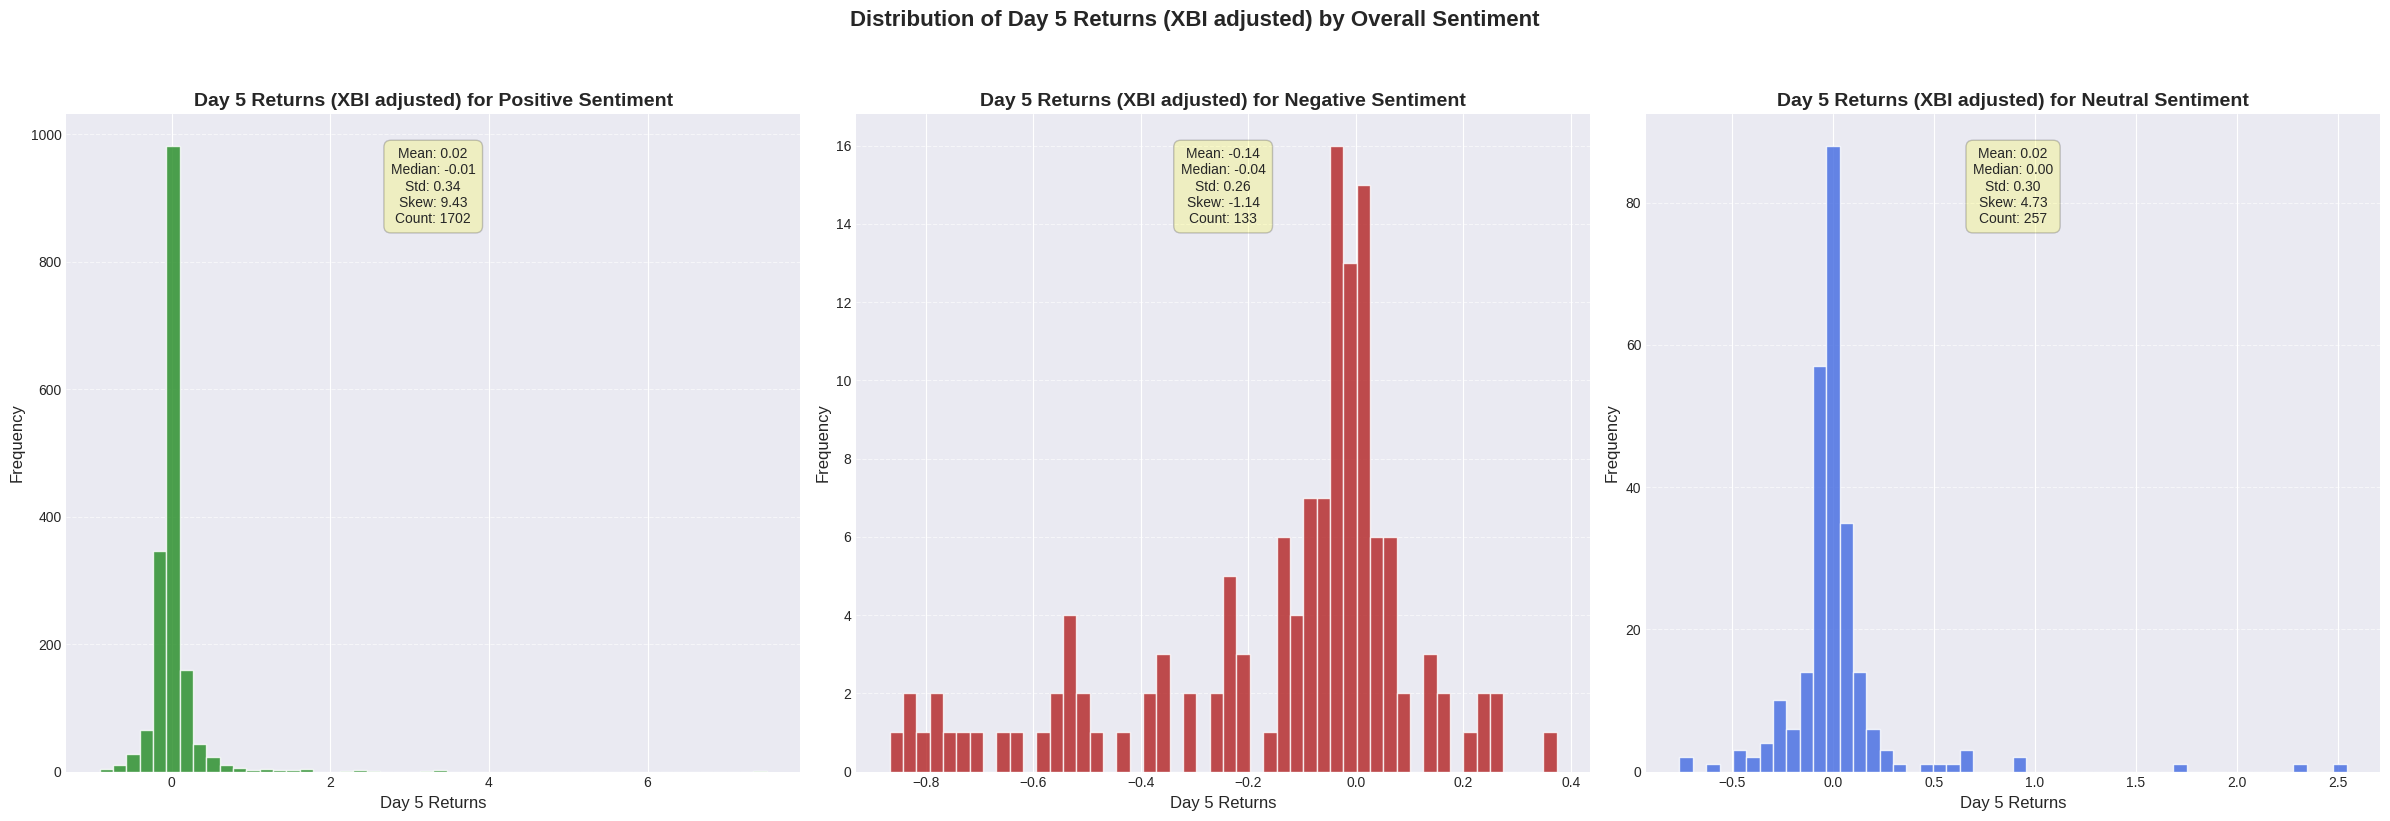

In [ ]:
# looking at the distribution of returns across the training data
# Filter the DataFrame for headline_sentiment = 1, -1, and 0
returns_sentiment_pos = df_train[df_train['total_net'] > 0]['XBI_Adjusted_Perc_Return_D5']
returns_sentiment_neg = df_train[df_train['total_net'] < 0]['XBI_Adjusted_Perc_Return_D5']
returns_sentiment_neu = df_train[df_train['total_net'] == 0]['XBI_Adjusted_Perc_Return_D5']

# Calculate summary statistics for each sentiment category, including skewness
stats_pos = returns_sentiment_pos.agg(['mean', 'median', 'std', 'count', 'skew'])
stats_neg = returns_sentiment_neg.agg(['mean', 'median', 'std', 'count', 'skew'])
stats_neu = returns_sentiment_neu.agg(['mean', 'median', 'std', 'count', 'skew'])

# Apply a style for a prettier look
plt.style.use('seaborn-v0_8-darkgrid') # Using a seaborn style for enhanced aesthetics

plt.figure(figsize=(24, 8)) # Adjust figure size to accommodate three subplots and subtitles

# Subplot 1: headline_sentiment = 1
plt.subplot(1, 3, 1) # 1 row, 3 columns, first plot
plt.hist(returns_sentiment_pos, bins=50, color='forestgreen', edgecolor='white', alpha=0.8)
plt.title('Day 5 Returns (XBI adjusted) for Positive Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Day 5 Returns', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.text(0.5, 0.95, f"Mean: {stats_pos['mean']:.2f}\nMedian: {stats_pos['median']:.2f}\nStd: {stats_pos['std']:.2f}\nSkew: {stats_pos['skew']:.2f}\nCount: {int(stats_pos['count'])}",
         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.2))

# Subplot 2: headline_sentiment = -1
plt.subplot(1, 3, 2) # 1 row, 3 columns, second plot
plt.hist(returns_sentiment_neg, bins=50, color='firebrick', edgecolor='white', alpha=0.8)
plt.title('Day 5 Returns (XBI adjusted) for Negative Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Day 5 Returns', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.text(0.5, 0.95, f"Mean: {stats_neg['mean']:.2f}\nMedian: {stats_neg['median']:.2f}\nStd: {stats_neg['std']:.2f}\nSkew: {stats_neg['skew']:.2f}\nCount: {int(stats_neg['count'])}",
         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.2))

# Subplot 3: headline_sentiment = 0
plt.subplot(1, 3, 3) # 1 row, 3 columns, third plot
plt.hist(returns_sentiment_neu, bins=50, color='royalblue', edgecolor='white', alpha=0.8)
plt.title('Day 5 Returns (XBI adjusted) for Neutral Sentiment', fontsize=14, fontweight='bold')
plt.xlabel('Day 5 Returns', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.text(0.5, 0.95, f"Mean: {stats_neu['mean']:.2f}\nMedian: {stats_neu['median']:.2f}\nStd: {stats_neu['std']:.2f}\nSkew: {stats_neu['skew']:.2f}\nCount: {int(stats_neu['count'])}",
         horizontalalignment='center', verticalalignment='top', transform=plt.gca().transAxes, fontsize=10, bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.2))

plt.suptitle('Distribution of Day 5 Returns (XBI adjusted) by Overall Sentiment', fontsize=16, fontweight='bold', y=1.02) # Overall title
plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to prevent overlap with suptitle
plt.savefig("/content/drive/My Drive/DS266/Final Project/BERT-BASE/out/5day_return_histogram_xbi_adjusted_by_sentiment_new.png", dpi=400)
plt.show()

Check to see how the actual labels match up in the predictions

In [ ]:
def clean_up_labels(labels):
  to_keep = []
  for label in labels:
    if label.startswith("B"):
      to_keep.append(label[2:])
  return to_keep

def categorize_labels(predicted_labels, true_labels):
    predicted_set = set(predicted_labels)
    true_set = set(true_labels)

    if predicted_set == true_set:
        return 'Perfect Match'
    elif predicted_set.issubset(true_set):
        return 'Missing Labels'
    elif predicted_set.issuperset(true_set):
        return 'Overclassified Labels'
    elif predicted_set.intersection(true_set):
        return 'Partial Match'
    else:
        return 'No Match'
print("categorize_labels function redefined.")

categorize_labels function redefined.


In [ ]:
df_predictions_comparison = pd.DataFrame({
    'Predicted Labels': true_preds_biobert,
    'True Labels': true_labels_biobert,
    'Catalyst': df_test['Catalyst']
})
display(df_predictions_comparison.head())

,Predicted Labels,True Labels,Catalyst
0,"[O, O, O, O, O, O, O, B-EFF_POS, O, I-EFF_POS,...","[O, O, O, O, O, O, O, O, O, O, B-EFF_NEG, I-EF...",Phase 2 interim data from MDS reported that at...
1,"[O, O, O, O, O, O, O, B-EFF_POS, I-EFF_POS, I-...","[O, O, O, O, O, O, O, O, B-EFF_POS, I-EFF_POS,...",Phase 2 data presented at ASTRO showed 100% 36...
2,"[B-REG_POS, I-REG_POS, I-REG_POS, I-REG_POS, I...","[B-REG_POS, I-REG_POS, I-REG_POS, I-REG_POS, I...","IND cleared by the FDA, noted October 2, 2024."
3,"[O, O, O, O, O, O, O, O, O, B-EFF_POS, I-EFF_P...","[O, O, O, O, O, O, O, O, O, B-EFF_POS, I-EFF_P...",Additional Phase 1b/2a data from post hoc anal...
4,"[O, O, O, B-CLIN_POS, O, O, O, O, O]","[O, O, O, B-CLIN_POS, O, O, O, O, O]","Phase 3 trial dosing initiated, noted October ..."


In [ ]:
for column in df_predictions_comparison.columns:
  if column == 'Catalyst': continue
  for row in range(len(df_predictions_comparison)):
    df_predictions_comparison.at[row,column] = clean_up_labels(df_predictions_comparison.at[row,column])

display(df_predictions_comparison)

,Predicted Labels,True Labels,Catalyst
0,[EFF_POS],"[EFF_NEG, EFF_POS]",Phase 2 interim data from MDS reported that at...
1,[EFF_POS],"[EFF_POS, EFF_POS]",Phase 2 data presented at ASTRO showed 100% 36...
2,[REG_POS],[REG_POS],"IND cleared by the FDA, noted October 2, 2024."
3,[EFF_POS],[EFF_POS],Additional Phase 1b/2a data from post hoc anal...
4,[CLIN_POS],[CLIN_POS],"Phase 3 trial dosing initiated, noted October ..."
...,...,...,...
813,[],"[CLIN_NEG, SAFETY_NEG]",Phase 2 trial voluntarily halted all dosing du...
814,[EFF_POS],[SAFETY_POS],"Phase 2 trial met primary safety endpoint, not..."
815,[],[CLIN_NEG],"Development of uliledlimab is being paused, no..."
816,[ENROLL_POS],[ENROLL_POS],"Phase 2b enrollment completed, noted January 6..."


In [ ]:
df_predictions_comparison['Prediction_Quality'] = df_predictions_comparison.apply(lambda row: categorize_labels(row['Predicted Labels'], row['True Labels']), axis=1)
display(df_predictions_comparison)

,Predicted Labels,True Labels,Catalyst,Prediction_Quality
0,[EFF_POS],"[EFF_NEG, EFF_POS]",Phase 2 interim data from MDS reported that at...,Missing Labels
1,[EFF_POS],"[EFF_POS, EFF_POS]",Phase 2 data presented at ASTRO showed 100% 36...,Perfect Match
2,[REG_POS],[REG_POS],"IND cleared by the FDA, noted October 2, 2024.",Perfect Match
3,[EFF_POS],[EFF_POS],Additional Phase 1b/2a data from post hoc anal...,Perfect Match
4,[CLIN_POS],[CLIN_POS],"Phase 3 trial dosing initiated, noted October ...",Perfect Match
...,...,...,...,...
813,[],"[CLIN_NEG, SAFETY_NEG]",Phase 2 trial voluntarily halted all dosing du...,Missing Labels
814,[EFF_POS],[SAFETY_POS],"Phase 2 trial met primary safety endpoint, not...",No Match
815,[],[CLIN_NEG],"Development of uliledlimab is being paused, no...",Missing Labels
816,[ENROLL_POS],[ENROLL_POS],"Phase 2b enrollment completed, noted January 6...",Perfect Match


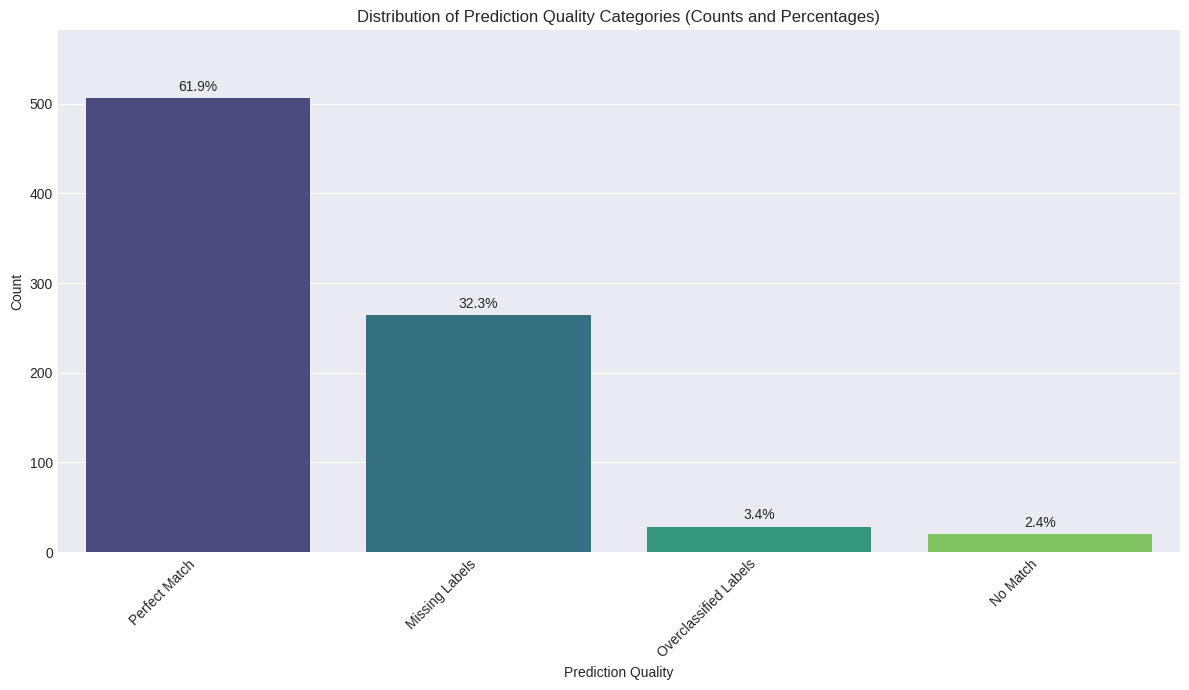

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each prediction quality category
quality_counts = df_predictions_comparison['Prediction_Quality'].value_counts()

# Calculate percentages
quality_percentages = quality_counts / len(df_predictions_comparison) * 100

# Create a bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x=quality_counts.index, y=quality_counts.values, palette='viridis', hue=quality_counts.index, legend=False)
plt.title('Distribution of Prediction Quality Categories (Counts and Percentages)')
plt.xlabel('Prediction Quality')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on top of the bars
for i, bar in enumerate(plt.gca().patches):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 5,  # Adjust vertical position for better visibility
             f'{quality_percentages.iloc[i]:.1f}%',
             ha='center', va='bottom', fontsize=10)

plt.ylim(0, quality_counts.max() * 1.15) # Adjust y-axis limit to make space for labels
plt.tight_layout()
plt.show()

### Additional analysis on the number of results on each type of label

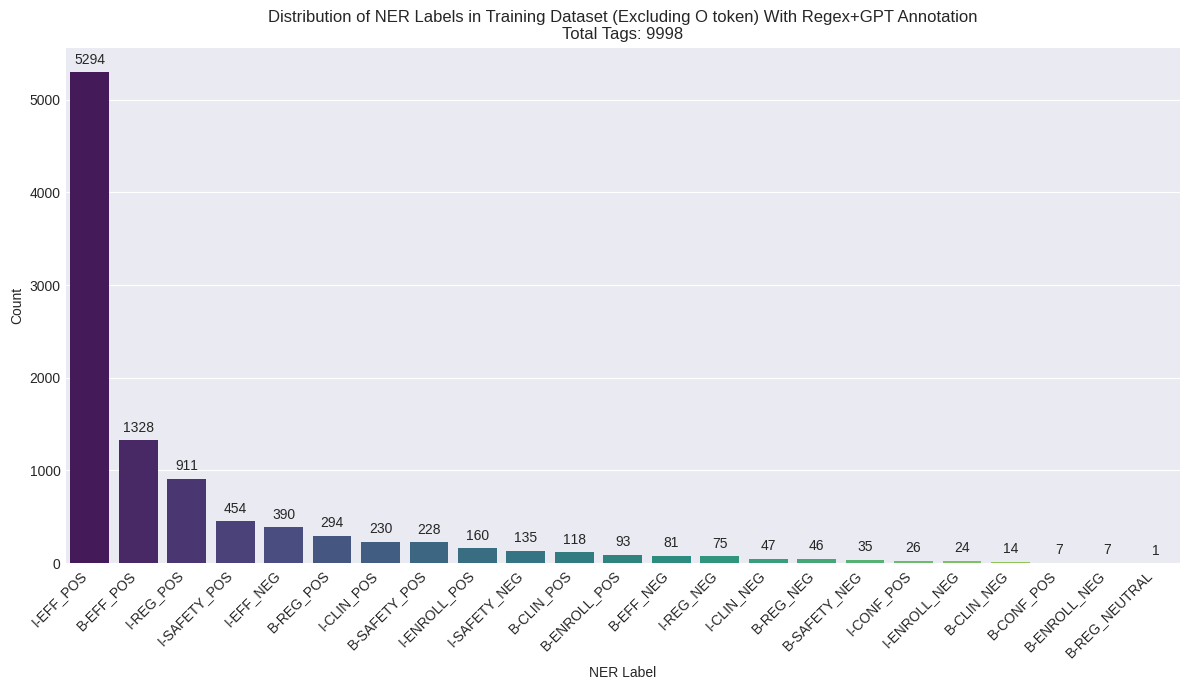

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Flatten the list of lists of tags from the training set
all_train_tags = [tag for sublist in df_train['tags'] for tag in sublist]

# Count the occurrences of each tag
tag_counts = pd.Series(all_train_tags).value_counts()
tag_counts = tag_counts.drop('O')
total_tags = tag_counts.sum()

# Create a bar plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(x=tag_counts.index, y=tag_counts.values, palette='viridis', hue=tag_counts.index, legend=False)
plt.title(f'Distribution of NER Labels in Training Dataset (Excluding O token) With Regex+GPT Annotation\nTotal Tags: {total_tags}')
plt.xlabel('NER Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points')

plt.tight_layout()
plt.show()

### Continuing the added predictive analytics with XGBoost

In [ ]:
# print out the shapes of the dataframes
print("Shape of df_train:", df_train.shape)
print("Shape of df_test:", df_test.shape)

Shape of df_train: (2092, 41)
Shape of df_test: (818, 42)


In [ ]:
# calculate the XBI adjusted return to account for general biotech market trends
df_train['XBI_Adjusted_Perc_Return_D5'] = df_train['Perc_Return_D5'] - df_train['XBI_Return_D5']
df_test['XBI_Adjusted_Perc_Return_D5'] = df_test['Perc_Return_D5'] - df_test['XBI_Return_D5']

In [ ]:
# function to make buckets for the level of stock change
def make_buckets_5classes(percent):
  '''
  Very bad (0) -- below 35% reduction
  Bad (1) -- between 5% to 35% reduction
  Neutral (2) -- between 5% increase to 5% reduction
  Good (3) -- between 5% to 35% increase
  Very good (4) -- above 50% increase
  '''
  if percent <= -0.35: return 0
  elif percent <= -0.05: return 1
  elif percent <= 0.05: return 2
  elif percent <= 0.35: return 3
  else: return 4

label_map_5classes = {0: "LARGE DROP (-35% or more)", 1: "DROP (between -5% to -35%)", 2:"NEUTRAL (between 5% to -5%)", 3:"INCREASE (between 5% to 35%)", 4:"LARGE INCREASE (35% or more)"}

df_train["bucket"] = df_train["XBI_Adjusted_Perc_Return_D5"].apply(make_buckets_5classes)
df_test["bucket"] = df_test["XBI_Adjusted_Perc_Return_D5"].apply(make_buckets_5classes)

In [ ]:
# print out the shapes of the dataframes
print("Shape of df_train:", df_train.shape)
print("Shape of df_test:", df_test.shape)

Shape of df_train: (2092, 42)
Shape of df_test: (818, 43)


In [ ]:
column_in_xgb = ['Stage', 'Shares_Millions', 'Market_Cap', 'Volatility', 'Short_Interest_Pct', 'Year_Beta',
       'Daily_Volum_Traded', 'count_REG_POS', 'count_ENROLL_POS', 'count_CLIN_POS', 'count_EFF_NEG', 'count_CONF_POS',
       'count_REG_NEG', 'count_SAFETY_NEG', 'count_EFF_POS',
       'count_ENROLL_NEG', 'count_SAFETY_POS', 'effect_net', 'regulatory_net',
       'safety_net', 'clinical_ops_net', 'total_net', 'bucket']

In [ ]:
# select all the columns for xgb first
df_train = df_train[column_in_xgb]
df_test = df_test[column_in_xgb]

# define columns that will be one-hot encoded
categorical_cols_for_ohe = ['Stage']

# apply one-hot encoding and drop specified columns for training and testing data
df_train_X_processed = df_train.drop(columns=['bucket'])
df_train_X_processed = pd.get_dummies(df_train_X_processed, columns=categorical_cols_for_ohe, drop_first=True)
df_test_X_processed = df_test.drop(columns=['bucket'])
df_test_X_processed = pd.get_dummies(df_test_X_processed, columns=categorical_cols_for_ohe, drop_first=True)

# align columns between training and testing sets and ensure the order of columns is the same for both dataframes
train_cols = set(df_train_X_processed.columns)
test_cols = set(df_test_X_processed.columns)

missing_in_test = list(train_cols - test_cols)
for c in missing_in_test:
    df_test_X_processed[c] = 0

missing_in_train = list(test_cols - train_cols)
for c in missing_in_train:
    df_train_X_processed[c] = 0

df_test_X_processed = df_test_X_processed[df_train_X_processed.columns]

# convert all remaining columns to numeric, coercing errors, and fill any NaNs
for col in df_train_X_processed.columns:
    df_train_X_processed[col] = pd.to_numeric(df_train_X_processed[col], errors='coerce')
    df_test_X_processed[col] = pd.to_numeric(df_test_X_processed[col], errors='coerce')

df_train_X_processed.fillna(0, inplace=True)
df_test_X_processed.fillna(0, inplace=True)

# final X and Y split for XGBoost
df_train_X = df_train_X_processed
df_train_Y = df_train['bucket']

df_test_X = df_test_X_processed
df_test_Y = df_test['bucket']

In [ ]:
# print the shapes of the new dataframes
print("Shape of df_train_X:", df_train_X.shape)
print("Shape of df_train_Y:", df_train_Y.shape)
print("Shape of df_test_X:", df_test_X.shape)
print("Shape of df_test_Y:", df_test_Y.shape)

# print out the columns in each of the dataframes
print("Columns in df_train_X:", df_train_X.columns)
print("Columns in df_train_Y:", df_train_Y.name)
print("Columns in df_test_X:", df_test_X.columns)
print("Columns in df_test_Y:", df_test_Y.name)

Shape of df_train_X: (2092, 39)
Shape of df_train_Y: (2092,)
Shape of df_test_X: (818, 39)
Shape of df_test_Y: (818,)
Columns in df_train_X: Index(['Shares_Millions', 'Market_Cap', 'Volatility', 'Short_Interest_Pct',
       'Year_Beta', 'Daily_Volum_Traded', 'count_REG_POS', 'count_ENROLL_POS',
       'count_CLIN_POS', 'count_EFF_NEG', 'count_CONF_POS', 'count_REG_NEG',
       'count_SAFETY_NEG', 'count_EFF_POS', 'count_ENROLL_NEG',
       'count_SAFETY_POS', 'effect_net', 'regulatory_net', 'safety_net',
       'clinical_ops_net', 'total_net', 'Stage_BLA Filing', 'Stage_BsUFA',
       'Stage_CRL', 'Stage_IND-Enabling', 'Stage_NDA Filing', 'Stage_PDUFA',
       'Stage_PDUFA priority review', 'Stage_Phase 1', 'Stage_Phase 1/2',
       'Stage_Phase 1a', 'Stage_Phase 1b', 'Stage_Phase 2', 'Stage_Phase 2/3',
       'Stage_Phase 2a', 'Stage_Phase 2b', 'Stage_Phase 3',
       'Stage_Preclinical', 'Stage_sNDA Filing'],
      dtype='object')
Columns in df_train_Y: bucket
Columns in df_test_X: I

In [ ]:
# train xgboost model
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    eval_metric="mlogloss",
    enable_categorical = True
)

model.fit(df_train_X, df_train_Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(df_test_X)
accuracy = accuracy_score(df_test_Y, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4756


In [ ]:
report = classification_report(df_test_Y, y_pred, target_names=label_map_5classes.values())
print("Classification Report:\n", report)

Classification Report:
                               precision    recall  f1-score   support

   LARGE DROP (-35% or more)       0.36      0.13      0.19        31
  DROP (between -5% to -35%)       0.44      0.43      0.43       264
 NEUTRAL (between 5% to -5%)       0.57      0.74      0.64       341
INCREASE (between 5% to 35%)       0.11      0.07      0.09       145
LARGE INCREASE (35% or more)       0.48      0.27      0.34        37

                    accuracy                           0.48       818
                   macro avg       0.39      0.33      0.34       818
                weighted avg       0.44      0.48      0.45       818



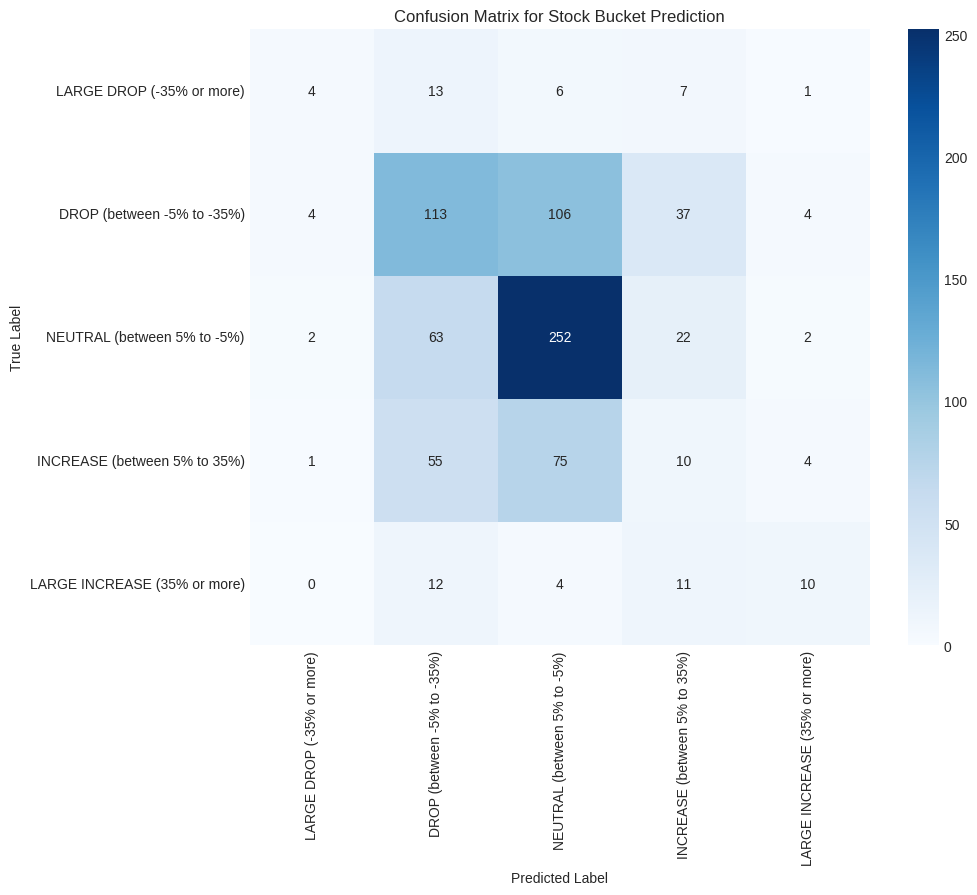

In [ ]:
# compute confusion matrix
cm = confusion_matrix(df_test_Y, y_pred)
labels = [label_map_5classes[i] for i in sorted(label_map_5classes.keys())]

# plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Stock Bucket Prediction')
plt.show()

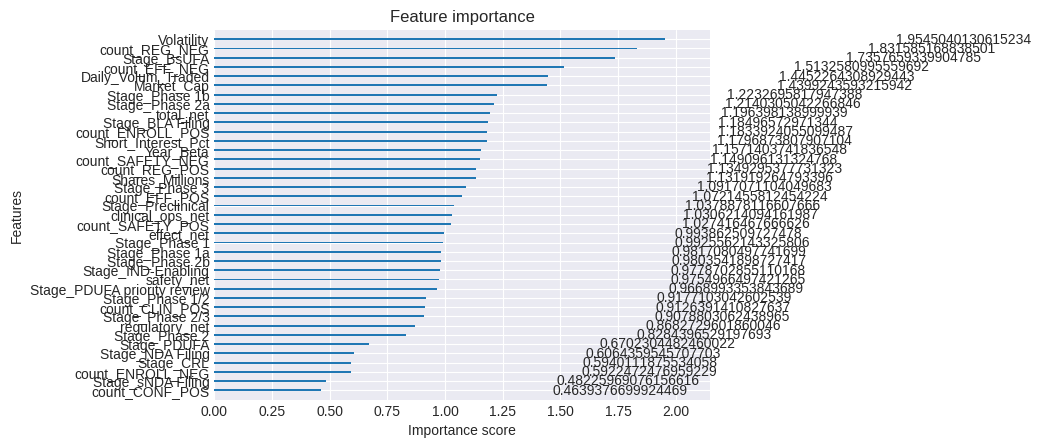

In [ ]:
xgb.plot_importance(model, importance_type="gain")
plt.show()

/tmp/ipython-input-1684993515.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, df_test_X)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: Futur

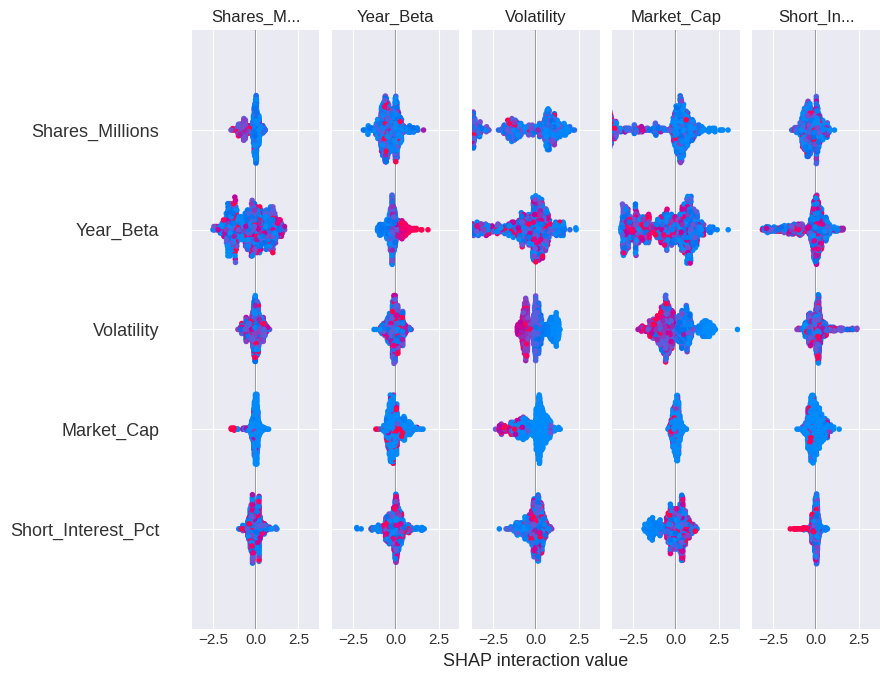

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(df_test_X)
shap.summary_plot(shap_values, df_test_X)

In [ ]:
importances = model.get_booster().get_score(importance_type='gain')

# Filter features with importance score > 1
important_features = [f for f, score in importances.items() if score > 1]

print("Selected features with importance score > 1:")
print(important_features)

Selected features with importance score > 1:
['Shares_Millions', 'Market_Cap', 'Volatility', 'Short_Interest_Pct', 'Year_Beta', 'Daily_Volum_Traded', 'count_REG_POS', 'count_ENROLL_POS', 'count_EFF_NEG', 'count_REG_NEG', 'count_SAFETY_NEG', 'count_EFF_POS', 'count_SAFETY_POS', 'clinical_ops_net', 'total_net', 'Stage_BLA Filing', 'Stage_BsUFA', 'Stage_Phase 1b', 'Stage_Phase 2a', 'Stage_Phase 3', 'Stage_Preclinical']


/tmp/ipython-input-3801083333.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=importance_series.values, y=importance_series.index, palette=colors, legend=False)


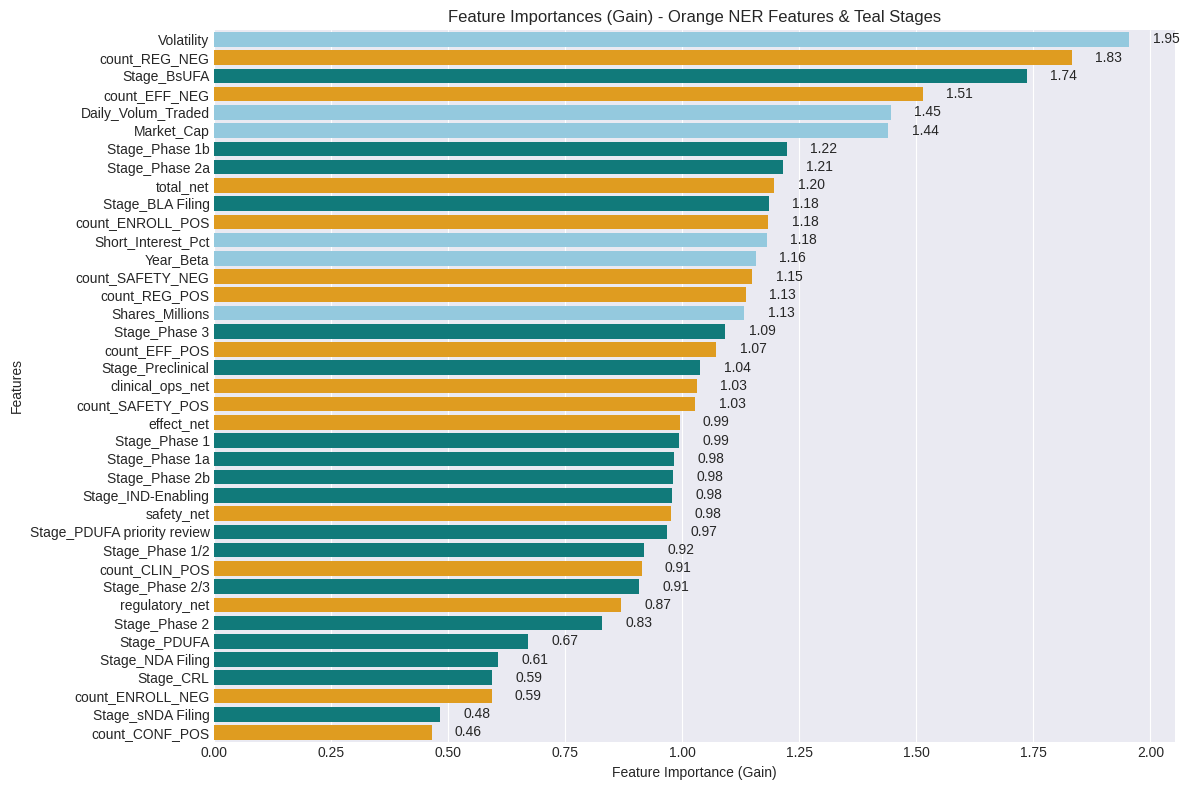

In [ ]:
# get feature importances from the trained model
importances = model.get_booster().get_score(importance_type='gain')
importance_series = pd.Series(importances).sort_values(ascending=False)

# define colors
def get_color(feature_name):
    if feature_name.startswith('count_') or feature_name.endswith('_net'):
        return 'orange'  # Highlight color for NER-derived features
    elif feature_name.startswith('Stage_'):
        return 'darkcyan'  # Highlight color for Stage_
    else:
        return 'skyblue' # Default color for other features

colors = [get_color(f) for f in importance_series.index]

# create the bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=importance_series.values, y=importance_series.index, palette=colors, legend=False)
plt.title('Feature Importances (Gain) - Orange NER Features & Teal Stages')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Features')

# add actual values on the right of each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.05, p.get_y() + p.get_height() / 2,    # Place text to the right of the bar
             '{:1.2f}'.format(width),                         # Format the value
             va='center')                                     # Center vertically

plt.tight_layout()
plt.show()

In [ ]:
# final X and Y split for XGBoost
df_train_X_topfeatures = df_train_X_processed[important_features]
df_train_Y_topfeatures = df_train['bucket']

df_test_X_topfeatures = df_test_X_processed[important_features]
df_test_Y_topfeatures = df_test['bucket']

In [ ]:
# train xgboost model with new features
model_topfeatures = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    objective="multi:softprob",
    eval_metric="mlogloss",
    enable_categorical = True
)

model_topfeatures.fit(df_train_X_topfeatures, df_train_Y_topfeatures)

y_pred_topfeatures = model_topfeatures.predict(df_test_X_topfeatures)
accuracy_topfeatures = accuracy_score(df_test_Y_topfeatures, y_pred_topfeatures)
print(f"Accuracy with reselected features: {accuracy_topfeatures:.4f}")

report_topfeatures = classification_report(df_test_Y_topfeatures, y_pred_topfeatures, target_names=label_map_5classes.values())
print("Classification Report with reselected features:\n", report_topfeatures)

Accuracy with reselected features: 0.4817
Classification Report with reselected features:
                               precision    recall  f1-score   support

   LARGE DROP (-35% or more)       0.50      0.16      0.24        31
  DROP (between -5% to -35%)       0.44      0.46      0.45       264
 NEUTRAL (between 5% to -5%)       0.58      0.73      0.64       341
INCREASE (between 5% to 35%)       0.11      0.06      0.08       145
LARGE INCREASE (35% or more)       0.56      0.27      0.36        37

                    accuracy                           0.48       818
                   macro avg       0.44      0.34      0.36       818
                weighted avg       0.45      0.48      0.45       818



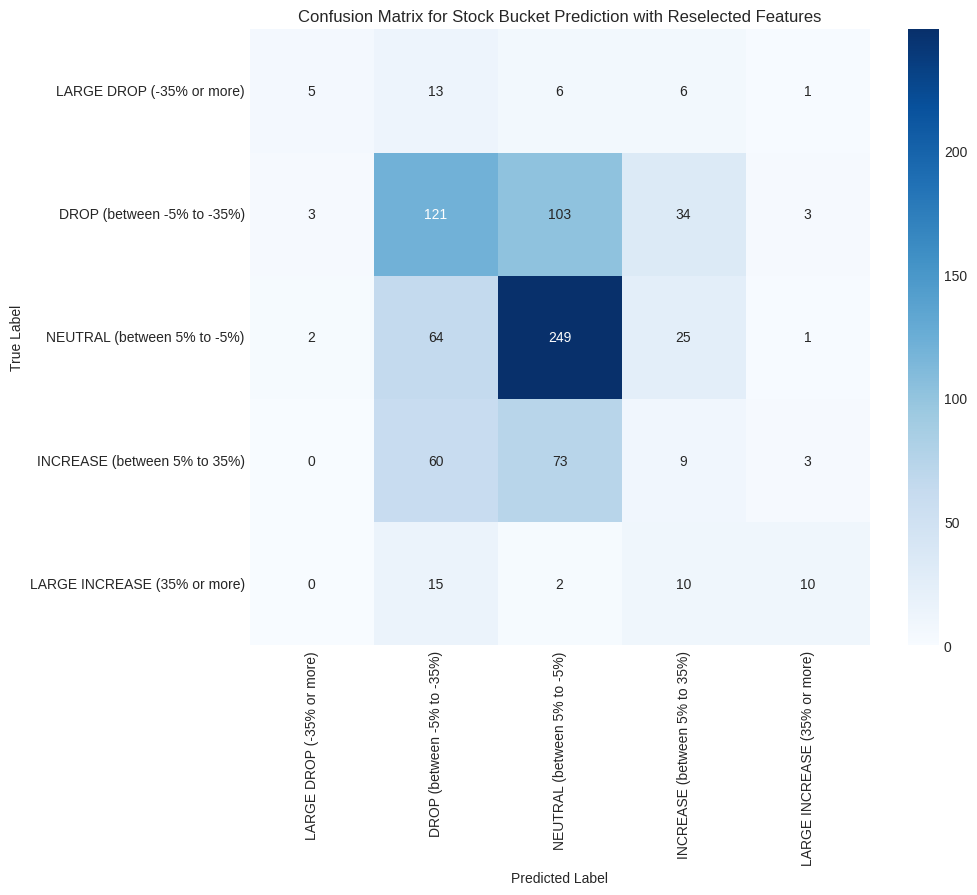

In [ ]:
cm = confusion_matrix(df_test_Y_topfeatures, y_pred_topfeatures)
labels = [label_map_5classes[i] for i in sorted(label_map_5classes.keys())]

# plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Stock Bucket Prediction with Reselected Features')
plt.show()

### Trying to use the best hyperparameters to maximize the results

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

X_train_split, X_val, y_train_split, y_val = train_test_split(
    df_train_X, df_train_Y, test_size=0.2, random_state=SEED, stratify=df_train_Y
)

In [ ]:
# instantiate XGBClassifier
xgb_model = XGBClassifier(
    objective="multi:softprob",
    eval_metric="mlogloss",
    enable_categorical=True,
    use_label_encoder=False, # Suppress future warning
    seed=SEED
)

# create GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# fit GridSearchCV (without early stopping parameters during CV folds)
grid_search.fit(
    X_train_split, y_train_split
)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:06:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5, 6],
                         'n_estimators': [100, 200, 300, 500],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=2)

In [ ]:
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500, 'subsample': 0.9}
Best accuracy found:  0.5325765911854984


In [ ]:
best_model = XGBClassifier(
    **grid_search.best_params_,
    objective="multi:softprob",
    eval_metric="mlogloss",
    enable_categorical=True,
    use_label_encoder=False,
    seed=SEED
)

# train the best model on the entire training dataset
best_model.fit(df_train_X, df_train_Y)

print("Best XGBoost model instantiated and trained on the full training data.")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [06:06:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost model instantiated and trained on the full training data.


Accuracy with best model: 0.5012
Classification Report with best model:
                               precision    recall  f1-score   support

   LARGE DROP (-35% or more)       0.67      0.19      0.30        31
  DROP (between -5% to -35%)       0.45      0.51      0.48       264
 NEUTRAL (between 5% to -5%)       0.57      0.76      0.65       341
INCREASE (between 5% to 35%)       0.04      0.01      0.02       145
LARGE INCREASE (35% or more)       0.60      0.24      0.35        37

                    accuracy                           0.50       818
                   macro avg       0.47      0.34      0.36       818
                weighted avg       0.45      0.50      0.46       818



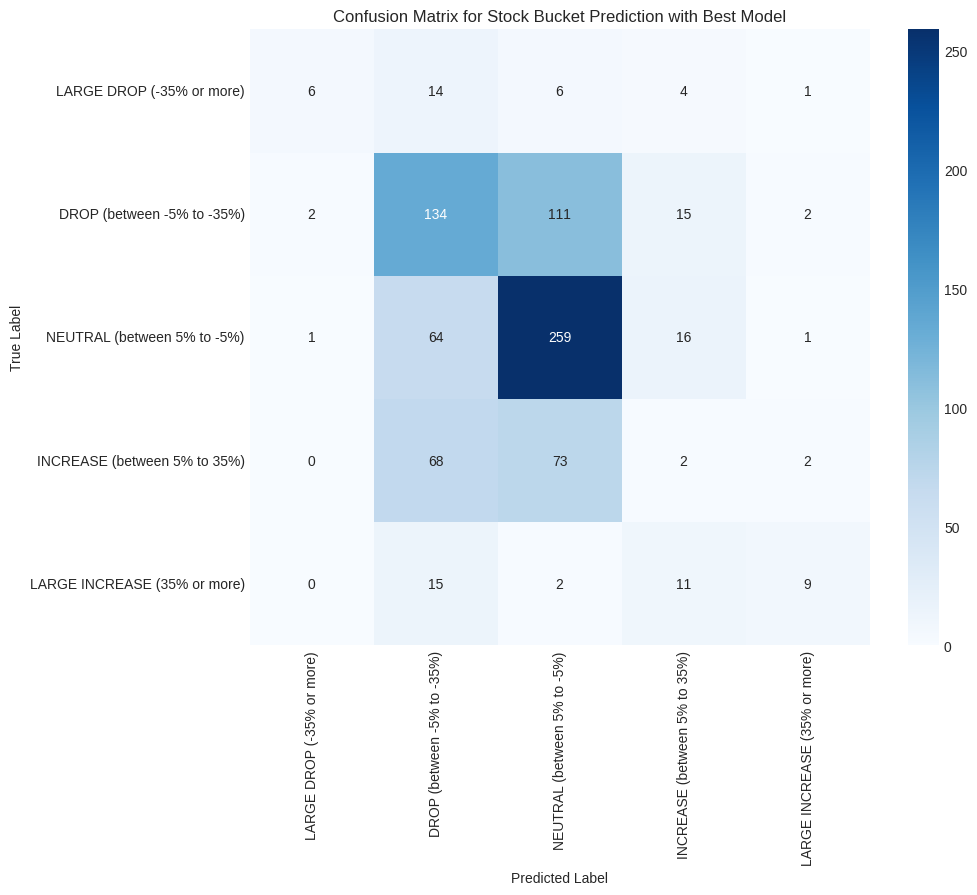

In [ ]:
y_pred_best = best_model.predict(df_test_X)
accuracy_best = accuracy_score(df_test_Y, y_pred_best)
print(f"Accuracy with best model: {accuracy_best:.4f}")

report_best = classification_report(df_test_Y, y_pred_best, target_names=label_map_5classes.values())
print("Classification Report with best model:\n", report_best)

# compute confusion matrix
cm_best = confusion_matrix(df_test_Y, y_pred_best)
labels_cm = [label_map_5classes[i] for i in sorted(label_map_5classes.keys())]

# plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues", xticklabels=labels_cm, yticklabels=labels_cm)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Stock Bucket Prediction with Best Model')
plt.show()

/tmp/ipython-input-2516051068.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=importance_series.values, y=importance_series.index, palette=colors, legend=False)


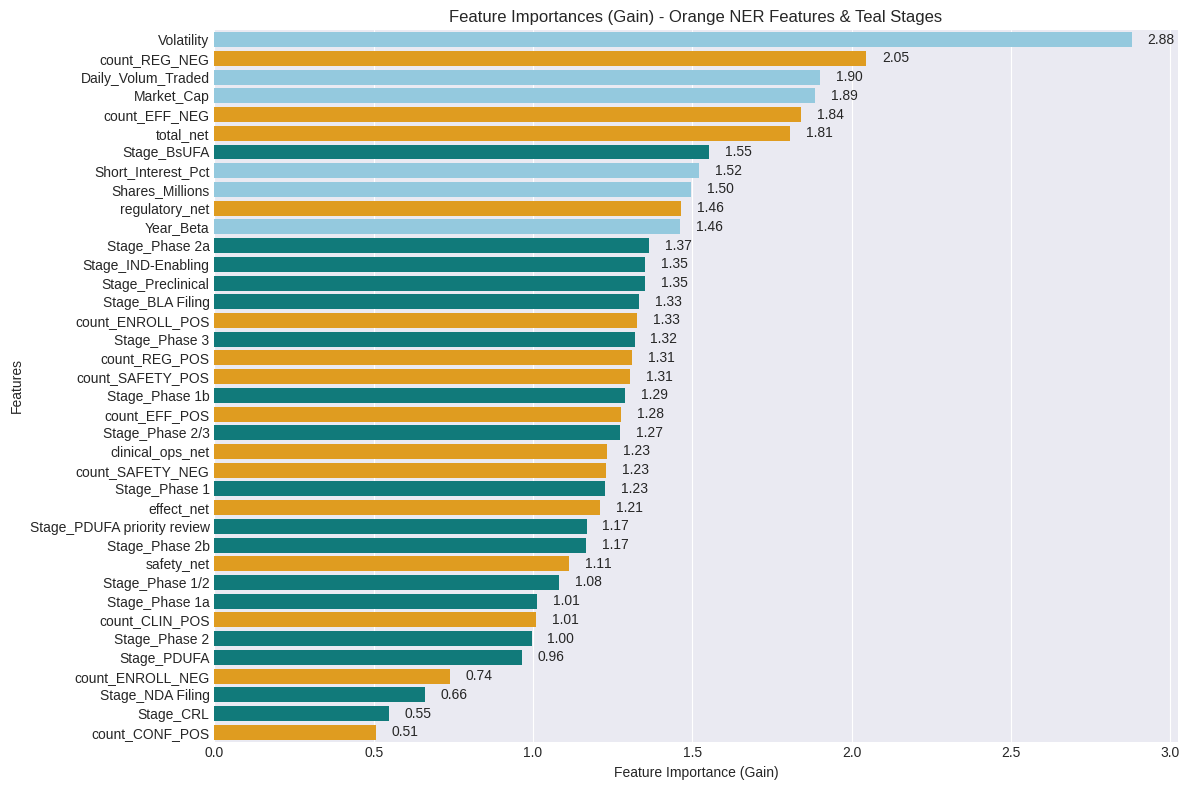

In [ ]:
# get feature importances from the trained model
importances = best_model.get_booster().get_score(importance_type='gain')
importance_series = pd.Series(importances).sort_values(ascending=False)

# define colors
def get_color(feature_name):
    if feature_name.startswith('count_') or feature_name.endswith('_net'):
        return 'orange'  # Highlight color for NER-derived features
    elif feature_name.startswith('Stage_'):
        return 'darkcyan'  # Highlight color for Stage_
    else:
        return 'skyblue' # Default color for other features

colors = [get_color(f) for f in importance_series.index]

# create the bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=importance_series.values, y=importance_series.index, palette=colors, legend=False)
plt.title('Feature Importances (Gain) - Orange NER Features & Teal Stages')
plt.xlabel('Feature Importance (Gain)')
plt.ylabel('Features')

# add actual values on the right of each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.05, p.get_y() + p.get_height() / 2,    # Place text to the right of the bar
             '{:1.2f}'.format(width),                         # Format the value
             va='center')                                     # Center vertically

plt.tight_layout()
plt.show()

### Summary:

*   A hyperparameter grid for XGBoost was defined, including `n_estimators`, `learning_rate`, `max_depth`, `subsample`, and `colsample_bytree`.
*   The training data was split into an 80% training subset and a 20% validation subset for hyperparameter tuning and early stopping, using a stratified split.
*   During the grid search, attempts to directly integrate early stopping within `GridSearchCV`'s cross-validation folds failed due to a `TypeError`, indicating a compatibility issue. As a result, early stopping was not applied during the cross-validation, and `n_estimators` was tuned as a fixed hyperparameter within the grid search.
*   The grid search successfully completed, exploring 1296 hyperparameter combinations.
*   The best hyperparameters identified by the grid search were: `colsample_bytree: 0.9`, `learning_rate: 0.01`, `max_depth: 6`, `n_estimators: 300`, and `subsample: 0.7`.
*   The best accuracy achieved during the grid search (on validation sets) was approximately 0.4866.
*   The final XGBoost model, trained with the best hyperparameters on the full training dataset, achieved an accuracy of 0.4450 on the independent test set.
*   Performance on the test set varied significantly across classes:
    *   The `VERY BAD` class showed high precision (0.75) but very low recall (0.09), suggesting the model rarely predicts this class, but when it does, it's often correct.
    *   The `BAD` and `NEUTRAL` classes had relatively better recall (0.60 and 0.52 respectively) and f1-scores (0.53 and 0.46 respectively).
    *   The `GOOD` class exhibited the lowest recall (0.18) and f1-score (0.24).
    *   Overall, the model achieved a macro average f1-score of 0.37 and a weighted average f1-score of 0.42 on the test set.
